In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import the required libraries
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [ ]:
#defining  important the attributes
IMAGE_SIZE=250
CHANNELS=3
BATCH_SIZE=32
EPOCHS=35
dataset = '/content/drive/MyDrive/ds/augmented_dataset/'

In [ ]:
# verify classes are balanced
def count_images(directory):
    image_count = 0
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        if os.path.isfile(img_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_count += 1
    return image_count

# Loop through each class (subdirectory) in the dataset directory
for subdir in os.listdir(dataset):
    class_dir = os.path.join(dataset, subdir)

    # Check if it's a directory
    if os.path.isdir(class_dir):
        # Count the number of images in this class directory
        image_count = count_images(class_dir)
        print(f"Class {subdir}: {image_count} images")
    else:
        print(f"{subdir} is not a directory.")

Class buildings: 210 images
Class river: 210 images
Class overpass: 210 images
Class baseballdiamond: 210 images
Class freeway: 210 images
Class sparseresidential: 210 images
Class golfcourse: 210 images
Class harbor: 210 images
Class mobilehomepark: 210 images
Class storagetanks: 210 images
Class beach: 210 images
Class agricultural: 210 images
Class airplane: 210 images
Class chaparral: 210 images
Class runway: 210 images
Class denseresidential: 210 images
Class tenniscourt: 210 images
Class forest: 210 images
Class parkinglot: 210 images
Class intersection: 210 images
Class mediumresidential: 210 images


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/ds/augmented_dataset/',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4410 files belonging to 21 classes.


In [ ]:
landuse_class_names = dataset.class_names
landuse_class_names

['agricultural',
 'airplane',
 'baseballdiamond',
 'beach',
 'buildings',
 'chaparral',
 'denseresidential',
 'forest',
 'freeway',
 'golfcourse',
 'harbor',
 'intersection',
 'mediumresidential',
 'mobilehomepark',
 'overpass',
 'parkinglot',
 'river',
 'runway',
 'sparseresidential',
 'storagetanks',
 'tenniscourt']

In [ ]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(250, 250, 3)


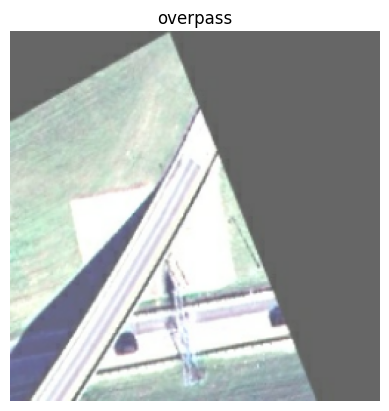

In [ ]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(landuse_class_names[label_batch[0]])
    plt.axis("off")

In [ ]:
# Extract class names from the dataset
class_names = dataset.class_names

# Prepare to display one image per class
plt.figure(figsize=(15, 15))

# Dictionary to store the first image path per class
class_first_image_paths = {}

# Iterate over the dataset to find and display the first image from each class
for images, labels in dataset:
    for image, label in zip(images, labels):
        class_name = class_names[label.numpy()]  # Get the class name from the label
        if class_name not in class_first_image_paths:
            # Store the path of the first image encountered for this class
            class_first_image_paths[class_name] = image
            # Display the first image found for this class
            plt.subplot(5, 5, len(class_first_image_paths))  # Adjust subplot position dynamically
            plt.imshow(image.numpy().astype("uint8"))
            plt.title(class_name)
            plt.axis("off")

        # Break loop if we have found one image per class
        if len(class_first_image_paths) == len(class_names):
            break

    # Break outer loop if we have found one image per class
    if len(class_first_image_paths) == len(class_names):
        break

plt.tight_layout()  # Adjust subplot layout to prevent overlap
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# function to split DS
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.2 ,test_split=0.1, shuffle=True, shuffle_size=10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_data_s = ds.take(train_size)
    val_data_s = ds.skip(train_size).take(val_size)
    test_data_s = ds.skip(train_size).skip(val_size)

    return train_data_s, val_data_s, test_data_s

train_data_s, val_data_s, test_data_s = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_data_s)

96

In [ ]:
len(val_data_s)

27

In [ ]:
len(test_data_s)

15

In [ ]:
train_data_s = train_data_s.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data_s = val_data_s.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data_s = test_data_s.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
     layers.experimental.preprocessing.Rescaling(1.0/255)
]
)

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 21

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size =(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size =(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),


])
model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 250, 250, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 248, 248, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 124, 124, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 122, 122, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 61, 61, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 59, 59, 64)         

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_data_s,
    epochs=50,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_data_s
)

Epoch 1/50
96/96 [==============================] - 233s 106ms/step - loss: 2.9907 - accuracy: 0.0662 - val_loss: 2.8736 - val_accuracy: 0.1042
Epoch 2/50
96/96 [==============================] - 3s 28ms/step - loss: 2.8255 - accuracy: 0.1145 - val_loss: 2.6862 - val_accuracy: 0.1562
Epoch 3/50
96/96 [==============================] - 3s 28ms/step - loss: 2.5824 - accuracy: 0.1794 - val_loss: 2.7043 - val_accuracy: 0.1377
Epoch 4/50
96/96 [==============================] - 3s 27ms/step - loss: 2.3669 - accuracy: 0.2401 - val_loss: 2.1393 - val_accuracy: 0.2951
Epoch 5/50
96/96 [==============================] - 3s 27ms/step - loss: 2.0021 - accuracy: 0.3545 - val_loss: 1.7738 - val_accuracy: 0.4282
Epoch 6/50
96/96 [==============================] - 3s 27ms/step - loss: 1.6974 - accuracy: 0.4524 - val_loss: 1.5932 - val_accuracy: 0.5058
Epoch 7/50
96/96 [==============================] - 3s 27ms/step - loss: 1.4235 - accuracy: 0.5486 - val_loss: 1.2584 - val_accuracy: 0.6088
Epoch 8/50

In [ ]:
import datetime

currentDT = datetime.datetime.now()
print(currentDT);
model_version="CNN-V1"
model.save(f"/content/drive/MyDrive/CNN/versions/{model_version}")

2024-04-18 07:32:39.774148


In [ ]:
scores = model.evaluate(test_data_s)
scores

15/15 [==============================] - 7s 14ms/step - loss: 1.1329 - accuracy: 0.8604


[1.1329087018966675, 0.8604166507720947]

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 96}

In [ ]:
history.history['accuracy']

[0.06621004641056061,
 0.11448141187429428,
 0.17938682436943054,
 0.24005217850208282,
 0.3545335829257965,
 0.4523809552192688,
 0.548597514629364,
 0.6343770623207092,
 0.6686236262321472,
 0.7553815841674805,
 0.7863665819168091,
 0.8281148076057434,
 0.8454011678695679,
 0.8848662972450256,
 0.8796477317810059,
 0.9037834405899048,
 0.9200913310050964,
 0.94585782289505,
 0.9383561611175537,
 0.9360730648040771,
 0.913241982460022,
 0.9302022457122803,
 0.9624918699264526,
 0.951076328754425,
 0.9344422817230225,
 0.9797782301902771,
 0.9690150022506714,
 0.9602087140083313,
 0.9465101361274719,
 0.9634703397750854,
 0.9885844588279724,
 0.9898890852928162,
 0.9298760890960693,
 0.9683626890182495,
 0.9752119779586792,
 0.9641226530075073,
 0.9817351698875427,
 0.9758642911911011,
 0.9748858213424683,
 0.9455316662788391,
 0.9732550382614136,
 0.9876059889793396,
 0.9970645904541016,
 0.9967384338378906,
 0.9967384338378906,
 0.9957599639892578,
 0.9938030242919922,
 0.99641227722

In [ ]:
acc=history.history['accuracy']
vali_acc=history.history['val_accuracy']
loss=history.history['loss']
vali_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

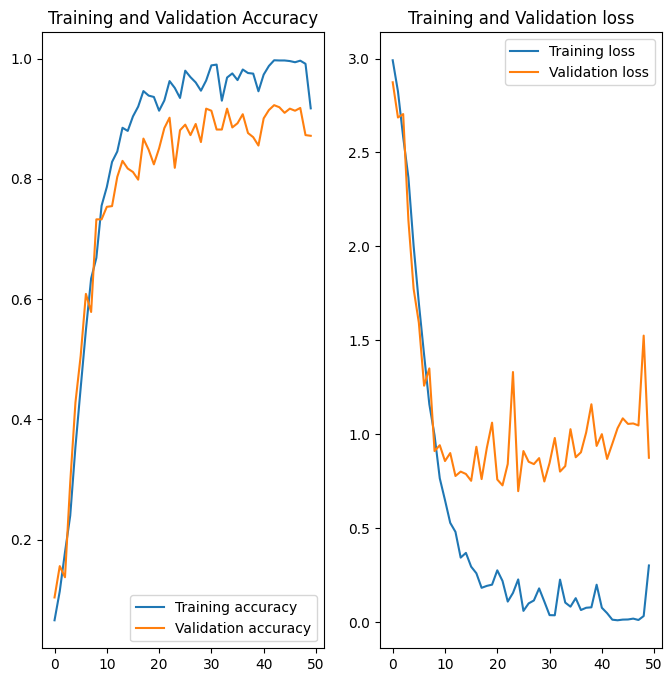

In [ ]:
EPOCHS=50
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training accuracy')
plt.plot(range(EPOCHS), vali_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), vali_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')

first image to predict
actual label:  forest
1/1 [==============================] - 0s 165ms/step
predicted label: forest


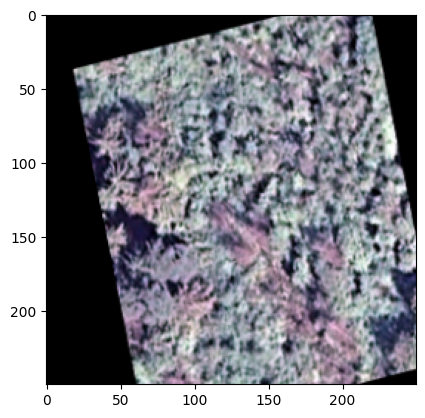

In [ ]:
for images_batch, labels_batch in test_data_s.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label= labels_batch [0].numpy()

    print("first image to predict")
    plt.imshow(first_image)

    print("actual label: ",landuse_class_names[first_label])
    batch_prediction=model.predict(images_batch)
    print("predicted label:",landuse_class_names[numpy.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):

    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions=model.predict(img_array)

    predicted_class= landuse_class_names[numpy.argmax(predictions[0])]
    confidence = round(100*(numpy.max(predictions[0])), 2)

    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(16, 16))
for images, labels in test_data_s.take(1):

    for i in range(16) :

        ax = plt.subplot(4, 4, i+1)
        plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class= landuse_class_names[labels[i]]

        # plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}")
        if actual_class == predicted_class:
            plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}", color='green')
        else:
            plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}", color='red')

        plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!pip install seaborn

1/1 [==============================] - 0s 21ms/step


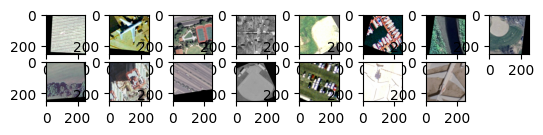

In [ ]:
y_pred = []
y_true = []
for images, labels in test_data_s:

    for i in range(len(test_data_s)) :

        ax = plt.subplot(8, 8, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class=landuse_class_names[labels[i]]
        y_pred.append(predicted_class)
        y_true.append(actual_class)

In [ ]:
y_true

['freeway',
 'baseballdiamond',
 'beach',
 'tenniscourt',
 'airplane',
 'harbor',
 'chaparral',
 'forest',
 'denseresidential',
 'tenniscourt',
 'baseballdiamond',
 'harbor',
 'tenniscourt',
 'buildings',
 'airplane',
 'chaparral',
 'parkinglot',
 'golfcourse',
 'parkinglot',
 'river',
 'river',
 'golfcourse',
 'overpass',
 'chaparral',
 'mobilehomepark',
 'mobilehomepark',
 'agricultural',
 'mediumresidential',
 'denseresidential',
 'tenniscourt',
 'freeway',
 'intersection',
 'overpass',
 'river',
 'airplane',
 'airplane',
 'parkinglot',
 'beach',
 'baseballdiamond',
 'harbor',
 'harbor',
 'sparseresidential',
 'agricultural',
 'river',
 'buildings',
 'freeway',
 'storagetanks',
 'chaparral',
 'baseballdiamond',
 'denseresidential',
 'runway',
 'golfcourse',
 'mobilehomepark',
 'intersection',
 'buildings',
 'chaparral',
 'beach',
 'agricultural',
 'baseballdiamond',
 'forest',
 'golfcourse',
 'tenniscourt',
 'golfcourse',
 'overpass',
 'airplane',
 'denseresidential',
 'forest',
 's

In [ ]:
y_pred

['freeway',
 'beach',
 'beach',
 'tenniscourt',
 'airplane',
 'harbor',
 'buildings',
 'forest',
 'denseresidential',
 'tenniscourt',
 'baseballdiamond',
 'harbor',
 'tenniscourt',
 'buildings',
 'intersection',
 'chaparral',
 'parkinglot',
 'golfcourse',
 'parkinglot',
 'overpass',
 'river',
 'golfcourse',
 'overpass',
 'chaparral',
 'parkinglot',
 'mobilehomepark',
 'agricultural',
 'mediumresidential',
 'denseresidential',
 'tenniscourt',
 'freeway',
 'golfcourse',
 'overpass',
 'river',
 'airplane',
 'airplane',
 'parkinglot',
 'beach',
 'beach',
 'harbor',
 'harbor',
 'golfcourse',
 'agricultural',
 'river',
 'buildings',
 'freeway',
 'storagetanks',
 'forest',
 'baseballdiamond',
 'denseresidential',
 'runway',
 'golfcourse',
 'mobilehomepark',
 'intersection',
 'airplane',
 'chaparral',
 'beach',
 'agricultural',
 'baseballdiamond',
 'forest',
 'golfcourse',
 'tenniscourt',
 'golfcourse',
 'overpass',
 'storagetanks',
 'parkinglot',
 'forest',
 'storagetanks',
 'beach',
 'golfco

Text(50.72222222222221, 0.5, 'True labels')

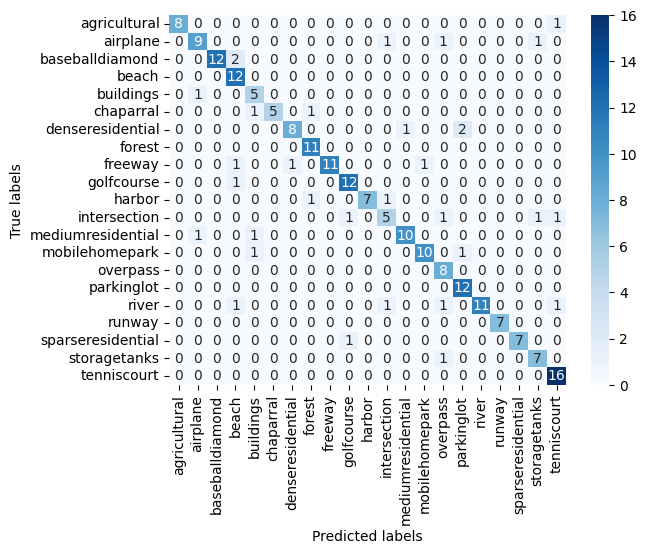

In [ ]:
# confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# assume y_true and y_pred are the true labels and predicted labels, respectively
cm = confusion_matrix(y_true, y_pred)

# define class names
landuse_class_names =['agricultural',
 'airplane',
 'baseballdiamond',
 'beach',
 'buildings',
 'chaparral',
 'denseresidential',
 'forest',
 'freeway',
 'golfcourse',
 'harbor',
 'intersection',
 'mediumresidential',
 'mobilehomepark',
 'overpass',
 'parkinglot',
 'river',
 'runway',
 'sparseresidential',
 'storagetanks',
 'tenniscourt']
# create heatmap with labeled axes
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# set labels
plt.xlabel('Predicted labels')
plt.ylabel('True labels')


In [ ]:
cm

array([[ 8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  1],
       [ 0,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0,
         0,  0,  0,  1,  0],
       [ 0,  0, 12,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  5,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0,  1,  0,  0,  2,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 11,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  1,  0, 11,  0,  0,  0,  0,  1,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0, 12,  0,  0,  0,  0,  0,  0,
         0,  0,  0,

In [ ]:
num_classes = 21  # classes
precision = []
recall = []

for i in range(num_classes):
    tp = cm[i, i]  # True positives for class i
    fp = sum(cm[:, i]) - tp  # False positives for class i
    fn = sum(cm[i, :]) - tp  # False negatives for class i

    # Calculate precision (p) and recall (r) for class i
    p = tp / (tp + fp) if (tp + fp) > 0 else 0.0  # Handle division by zero
    r = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # Handle division by zero

    # Append precision and recall to respective lists
    precision.append(p)
    recall.append(r)

print("Precision:", precision)
print("Recall:", recall)


Precision: [1.0, 0.8181818181818182, 1.0, 0.7058823529411765, 0.625, 1.0, 0.8888888888888888, 0.8461538461538461, 1.0, 0.8571428571428571, 1.0, 0.625, 0.9090909090909091, 0.9090909090909091, 0.6666666666666666, 0.8, 1.0, 1.0, 1.0, 0.7777777777777778, 0.8421052631578947]
Recall: [0.8888888888888888, 0.75, 0.8571428571428571, 1.0, 0.8333333333333334, 0.7142857142857143, 0.7272727272727273, 1.0, 0.7857142857142857, 0.9230769230769231, 0.7777777777777778, 0.5555555555555556, 0.8333333333333334, 0.8333333333333334, 1.0, 1.0, 0.7333333333333333, 1.0, 0.875, 0.875, 1.0]


In [ ]:
# calculate precision and recall for each class
num_classes = 4
precision = []
recall = []
for i in range(num_classes):
    tp = cm[i, i]
    fp = sum(cm[:, i]) - tp
    fn = sum(cm[i, :]) - tp
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    precision.append(p)
    recall.append(r)

print("Precision:", precision)
print("Recall:", recall)


Precision: [1.0, 0.8181818181818182, 1.0, 0.7058823529411765]
Recall: [0.8888888888888888, 0.75, 0.8571428571428571, 1.0]


In [ ]:
from sklearn.metrics import f1_score

# Calculate the F1 score
f1 = f1_score(y_true, y_pred, average='weighted')


In [ ]:
from sklearn.metrics import classification_report

# get the classification report, which includes F1 score for each class
report = classification_report(y_true, y_pred)

# print the classification report
print(report)


                   precision    recall  f1-score   support

     agricultural       1.00      0.89      0.94         9
         airplane       0.82      0.75      0.78        12
  baseballdiamond       1.00      0.86      0.92        14
            beach       0.71      1.00      0.83        12
        buildings       0.62      0.83      0.71         6
        chaparral       1.00      0.71      0.83         7
 denseresidential       0.89      0.73      0.80        11
           forest       0.85      1.00      0.92        11
          freeway       1.00      0.79      0.88        14
       golfcourse       0.86      0.92      0.89        13
           harbor       1.00      0.78      0.88         9
     intersection       0.62      0.56      0.59         9
mediumresidential       0.91      0.83      0.87        12
   mobilehomepark       0.91      0.83      0.87        12
         overpass       0.67      1.00      0.80         8
       parkinglot       0.80      1.00      0.89       

**SAVING MODEL**

In [ ]:
import os
from tensorflow.keras.models import load_model

# Assuming 'model' is your Keras model object
save_path = '/content/drive/MyDrive/CNN/models/CNN.h5'
model.save(save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**EXPLAINABILITY FOR LIME**

In [ ]:
! pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=ac22789bcc450d86b4acf4c8b7b67199079c9352e928a53b5e0ca939627590ec
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
# import all of the necessary libraries
import lime
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
# generate the LIME explanation
explainer = lime_image.LimeImageExplainer()
# Define a predict_proba function for your model
def predict_proba(images):
    # Make predictions with your model
    preds = model.predict(images)
    # Return the predicted probabilities
    return preds

def my_explain_instance(image):
  # Generate an explanation for the test image
  explanation = explainer.explain_instance(
    image,
    predict_proba,
    top_labels=3,
    num_samples=1000,
    labels=(0, 1)
)
# Generate an explanation for the test image
explanation = explainer.explain_instance(
    first_image,
    predict_proba,
    top_labels=3,
    num_samples=1000,
    labels=(0, 1)
)

# Show the top labels for the test image
print('Top labels for test image:')
for label in explanation.top_labels:
    print(label)

# Show the explanation for the top label
print('Explanation for top label:')
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
Top labels for test image:
7
20
0
Explanation for top label:


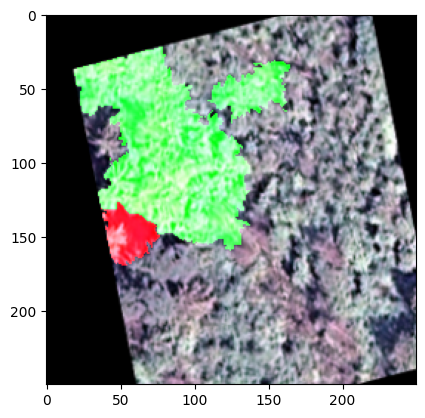

In [ ]:
# Visualize the resulting explanation
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Get the image and explanation as numpy arrays
image, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(image)

**SHAPLEY ADDIDITIVE EXPLAINABLILITY**

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 8.7 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

def get_image_for_prediction(dataset, class_names, image_size=(250, 250)):
    # Get the first image and label from the dataset
    for images_batch, labels_batch in dataset.take(1):
        first_image = images_batch[0].numpy().astype('uint8')
        first_label = labels_batch[0].numpy()

        # Display the image and print the actual label
        plt.imshow(first_image)
        plt.show()
        print("Actual label:", class_names[first_label])

        # Preprocess the image for model input
        image = tf.image.convert_image_dtype(first_image, tf.float32)
        image = tf.image.resize_with_pad(image, target_height=image_size[0], target_width=image_size[1])
        image = tf.expand_dims(image, axis=0)  # Add batch dimension

        return image



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

landuse_class_names = dataset.class_names

images_array = []  # Array to store the images

for images_batch, labels_batch in test_data_s.take(1):
    for i in range(20):  # Modify the range to specify the number of images you want
        image = images_batch[i].numpy().astype('uint8')
        label = labels_batch[i].numpy()

        print("Image to predict:", i+1)
        plt.imshow(image)
        plt.show()

        print("Actual label:", landuse_class_names[label])
        batch_prediction = model.predict(np.expand_dims(images_batch[i], axis=0))
        predicted_label = landuse_class_names[np.argmax(batch_prediction)]

        print("Predicted label:", predicted_label)
        images_array.append(image)

# images_array now contains the array of 5 images


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import shap
shap.initjs()
print(first_image.shape)
masker = shap.maskers.Image("inpaint_telea", first_image.shape)

explainer = shap.Explainer(model, masker, output_names=landuse_class_names)

explainer

(250, 250, 3)


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▌         | 1/20 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▌        | 3/20 [00:43<02:35,  9.15s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 4/20 [01:01<03:27, 12.95s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 5/20 [01:20<03:46, 15.13s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 6/20 [01:38<03:47, 16.22s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▌      | 7/20 [01:53<03:24, 15.74s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 8/20 [02:07<03:02, 15.18s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▌     | 9/20 [02:27<03:04, 16.74s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 10/20 [02:44<02:47, 16.76s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▌    | 11/20 [03:04<02:41, 17.96s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 12/20 [03:20<02:17, 17.25s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|██████▌   | 13/20 [03:33<01:52, 16.12s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 14/20 [03:49<01:36, 16.09s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 15/20 [04:11<01:28, 17.74s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 16/20 [04:36<01:19, 19.85s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▌ | 17/20 [04:52<00:56, 18.93s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 18/20 [05:08<00:35, 17.76s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▌| 19/20 [05:29<00:18, 18.78s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 20/20 [05:49<00:00, 19.10s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 21it [06:08, 18.42s/it]


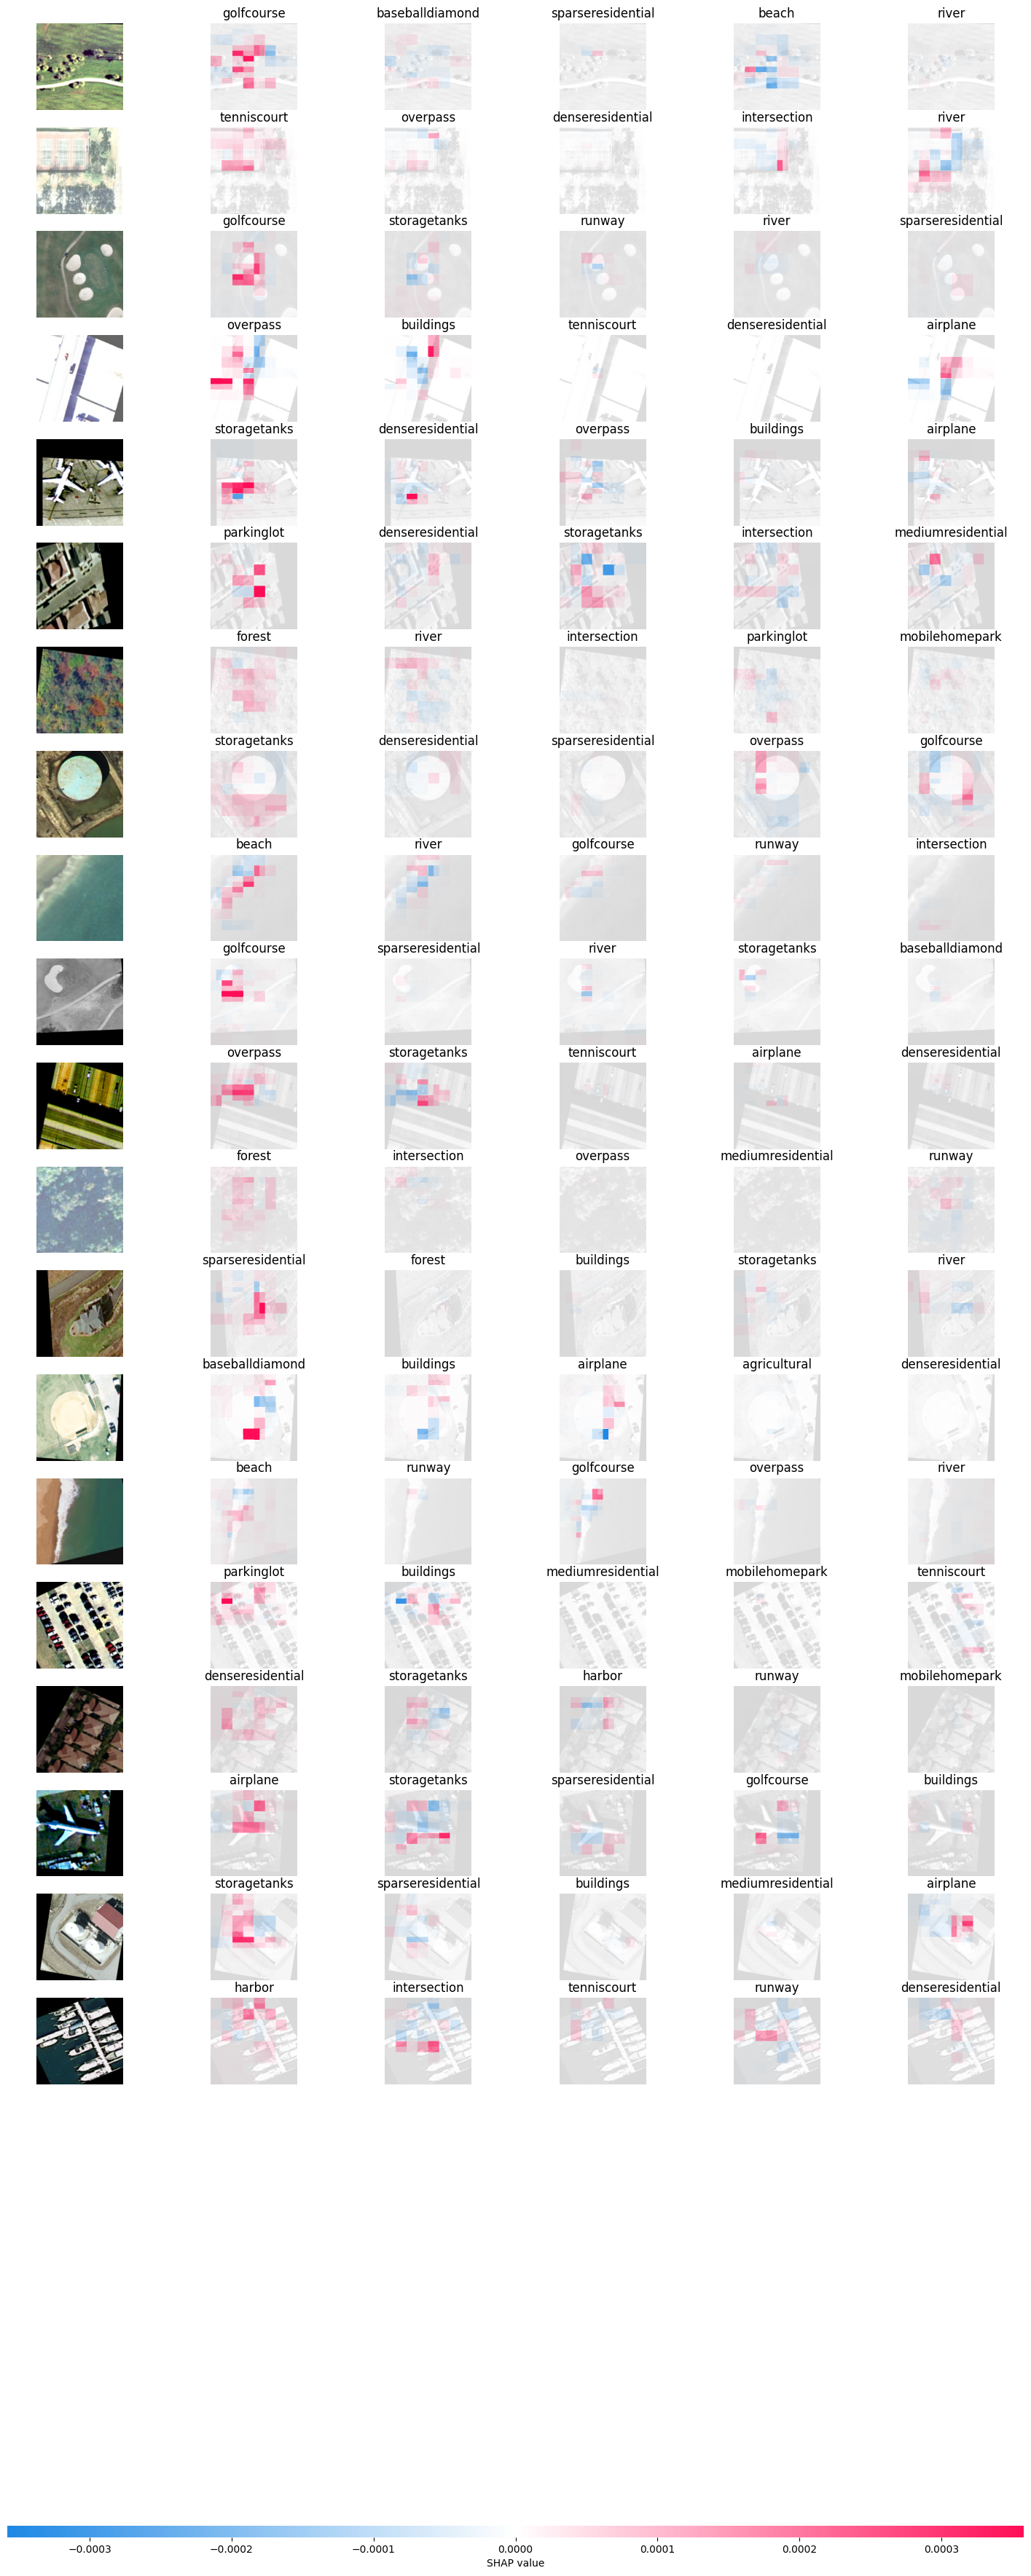

In [ ]:
import shap
# Convert the list of images to a numpy array
images_array = np.array(images_array)
shap_values = explainer(images_array, outputs=shap.Explanation.argsort.flip[:5])

shap_values.shape
shap.image_plot(shap_values)

**GRADCAM EXPLAINER**

In [ ]:
!pip install tensorflow matplotlib
!pip install gradcam
!pip install tf-explain



ERROR: Could not find a version that satisfies the requirement gradcam (from versions: none)
ERROR: No matching distribution found for gradcam
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.0 MB/s eta 0:00:00


First image to predict


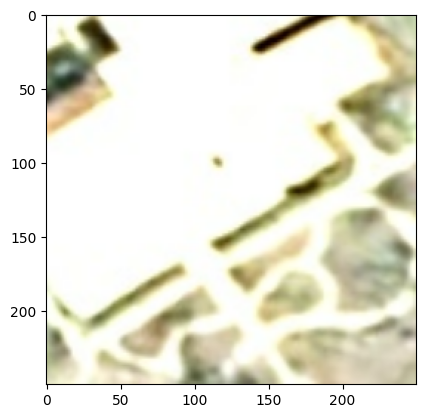

Actual label: sparseresidential
1/1 [==============================] - 0s 43ms/step
Predicted label: sparseresidential


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have defined your test dataset as test_data_s

# Get the first image and label from the test dataset
for images_batch, labels_batch in test_data_s.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    plt.show()

    print("Actual label:", landuse_class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("Predicted label:", landuse_class_names[np.argmax(batch_prediction[0])])

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    predicted_class = Disease_class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)

    return predicted_class, confidence

# Assuming you have defined Disease_class_names elsewhere


In [ ]:
from tf_explain.core.grad_cam import GradCAM
import tensorflow as tf

# model = tf.keras.models.load_model('path_to_your_model.h5')

# Load a sample image (or
img = tf.keras.preprocessing.image.img_to_array(first_image)
data = ([img], None)

# Start explainer
explainer = GradCAM()
grid = explainer.explain(data, model, class_index=first_label, layer_name="conv2d_4")  # 281 is the tabby cat index in ImageNet

# Save the visualization
explainer.save(grid, ".", "grad_cam.png")


**visualizing regions that contribute to the most specfic prediction**

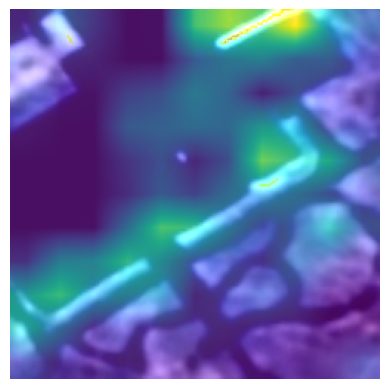

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Replace 'image_path' with the path to your saved GradCAM visualization image
image_path = "grad_cam.png"

# Load the image
img = mpimg.imread(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()
